In [1]:
# load library
import netCDF4 as nc

In [3]:
# read NetCDF file
fn = 'air.sig995.2012.nc'

data = nc.Dataset(fn, 'r') # 默认为读文件，此处 'r' 可省略

In [4]:
# 获取变量信息
data.variables.keys()

odict_keys(['lat', 'lon', 'time', 'air'])

In [5]:
data.dimensions.keys()  # 查看维度名称

odict_keys(['lat', 'lon', 'time'])

In [6]:
data.dimensions  # 每个维度的名称和大小

OrderedDict([('lat',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 73),
             ('lon',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 144),
             ('time',
              <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 1464)])

!后加系统命令，可以在notebook中执行系统命令，ncdump是用于查看netcdf格式文件的一个工具，-h 参数表示查看文件的头信息

In [7]:
# 使用 ncdump 查看 netcdf 文件变量, 维度和属性信息
!ncdump -h air.sig995.2012.nc

netcdf air.sig995.2012 {
dimensions:
	lat = 73 ;
	lon = 144 ;
	time = UNLIMITED ; // (1464 currently)
variables:
	float lat(lat) ;
		lat:units = "degrees_north" ;
		lat:actual_range = 90.f, -90.f ;
		lat:long_name = "Latitude" ;
		lat:standard_name = "latitude" ;
		lat:axis = "Y" ;
	float lon(lon) ;
		lon:units = "degrees_east" ;
		lon:long_name = "Longitude" ;
		lon:actual_range = 0.f, 357.5f ;
		lon:standard_name = "longitude" ;
		lon:axis = "X" ;
	double time(time) ;
		time:long_name = "Time" ;
		time:delta_t = "0000-00-00 06:00:00" ;
		time:standard_name = "time" ;
		time:axis = "T" ;
		time:units = "hours since 1800-01-01 00:00:0.0" ;
		time:actual_range = 1858344., 1867122. ;
	float air(time, lat, lon) ;
		air:long_name = "4xDaily Air temperature at sigma level 995" ;
		air:units = "degK" ;
		air:precision = 2s ;
		air:least_significant_digit = 1s ;
		air:GRIB_id = 11s ;
		air:GRIB_name = "TMP" ;
		air:var_desc = "Air temperature" ;
		air:level_desc = "Surface" ;
		air:statistic 

In [8]:
# 读取相关变量
lat = data.variables['lat'][:].data
lon = data.variables['lon'][:].data
time = data.variables['time'][:].data
air = data.variables['air'][:].data

In [9]:
# 获取每个变量的shape信息
# lat, lon, time是一维变量
# air 是关于时间和空间的三维变量
print(lat.shape, lon.shape, time.shape, air.shape) 

(73,) (144,) (1464,) (1464, 73, 144)


### 绘图部分

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

因为经纬度为规则网格，给定的经纬度数组为一维数组，在绘图之前需要根据经纬度数组进行网格化

In [10]:
LON, LAT = np.meshgrid(lon, lat)

In [11]:
LAT.shape

(73, 144)

sns.set_context 用于调整图形的一些参数，使其显示更美观，字体等更合适

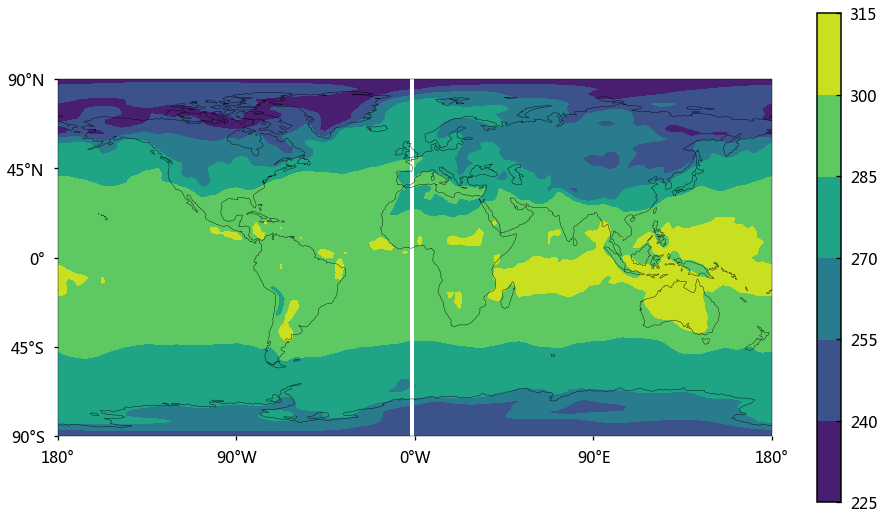

In [12]:
sns.set_context('talk', font_scale=1.2)

projection = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(16, 9), subplot_kw=dict(projection=projection))

con = ax.contourf(LON, LAT, air[0, ...])
ax.coastlines()   # 添加海岸线

ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)
ax.set_yticks(np.linspace(-90, 90, 5), crs=projection)

## x和y轴刻度经纬度显示方式
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

cb = fig.colorbar(con)

cb.ax.tick_params(direction='in', length=5) # 控制 colorbar tick

为了防止出现白色条状带，cartopy中提供了一个函数来添加数据循环，使其成为一个闭合数组。
palettable 是一个colormap工具包，如果没有，可使用 pip install  palettable 进行安装

In [13]:
from cartopy.util import add_cyclic_point  
from palettable.colorbrewer.diverging import RdBu_11_r 

In [14]:
cycle_air, cycle_lon = add_cyclic_point(air, coord=lon)

In [15]:
cycle_LON, cycle_LAT = np.meshgrid(cycle_lon, lat)

In [16]:
cycle_air.shape

(366, 73, 145)

In [17]:
cycle_LAT.shape

(73, 145)

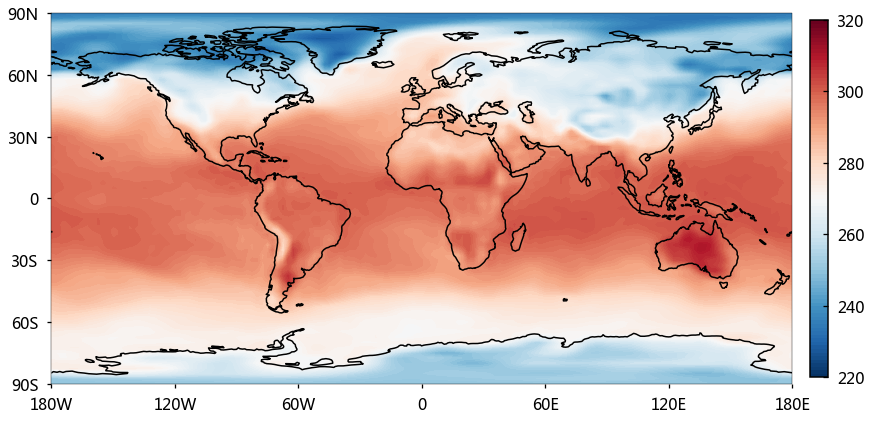

In [18]:
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(16, 9), subplot_kw=dict(projection=projection))

con = ax.contourf(cycle_LON, cycle_LAT, cycle_air[0, ...], np.arange(220, 321), cmap=RdBu_11_r.mpl_colormap)

ax.coastlines(linewidth=1.5) # 添加海岸线
ax.set_xticks(np.arange(-180, 181, 60), crs=projection)
ax.set_yticks(np.arange(-90, 91, 30), crs=projection)

# 设置 ticklabels 格式
lon_formatter = LongitudeFormatter(number_format='.0f',
                                   degree_symbol='',
                                   dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.0f',
                                  degree_symbol='')

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

cb = fig.colorbar(con, shrink=0.73, pad=0.02) # shrink 控制 colorbar 长度，pad 控制colorbar和图的距离

# 调整 ticklabels
cb.set_ticks(np.arange(220, 321, 20))
cb.set_ticklabels(np.arange(220, 321, 20))

cb.ax.tick_params(direction='in', length=5) # 控制 colorbar tick

#### 其它方式

使用 scipy 读取 netcdf 文件的方式和 netCDF4 类似，下面给出读取的简单示例

In [19]:
from scipy.io import netcdf

In [20]:
f = netcdf.netcdf_file('air.sig995.2012.nc', 'r')

In [21]:
f.variables.keys()

odict_keys(['lat', 'lon', 'time', 'air'])

In [22]:
# 读取相关变量
lat = data.variables['lat'][:].data
lon = data.variables['lon'][:].data
time = data.variables['time'][:].data
air = data.variables['air'][:].data